In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy.interpolate import interp1d

In [ ]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.simbad import Simbad

In [275]:
data_dir = "/epyc/data/"

In [9]:
bc = pd.read_csv('../data/BlackCATscrape.csv')

In [17]:
bc

,ID,Name \n(Counterpart),RA \n[hh:mm:ss],DEC \n[dd:mm:ss],ℓ\n[deg],b \n[deg],Magnitude\nOutburst (AB),Mag. \nQuies. (AB),d \n[kpc],fxpeak\n[2-10] keV\n[erg s-1 cm-2],Porb \n[h]
0,68,MAXI J1803-298,18:03:03,-29:49:50,1.147184,-3.727514,i'=16.01±0.01,NaN,NaN,3.960000e-09,NaN
1,67,AT2019wey \nSRGA J043520.9+552226 = ZTF19acwrvzk,4:35:23,55:22:34,151.161130,5.299730,r’=17.40±0.05,i’≥24.1,>1,2.400000e-08,<8.2
2,66,MAXI J0637-430,6:36:24,-42:52:05,251.532037,-20.674739,r’=15.80±0.01,i’>20.7,NaN,6.290000e-09,NaN
3,65,MAXI J1348-630,13:48:13,-63:16:28,309.264065,-1.102971,i’=14.44±0.08,i’=20.3±0.4,>3 / 2.2+0.5-0.6,1.970000e-08,NaN
4,64,MAXI J1631-479,16:31:14,-47:48:23,336.288139,0.312481,NaN,NaN,NaN,1.060000e-08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
63,5,1H 1659-487 \nGX 339-4 = V821 Ara,17:02:49,-48:47:23,338.939090,-4.326483,I=13.6±0.1,r=19.9±0.1,>5,2.560000e-08,42.21±0.01
64,4,4U 1755-338 \nV4134 Sgr,17:58:40,-33:48:27,357.215521,-4.872362,V∼18.5,V>21.96,6.5±2.5,1.170000e-09,∼4.4
65,3,4U 1543-475 \nIL Lup,15:47:08,-47:40:11,330.917871,5.426147,V=14.9,V=16.7,7.5±0.5,9.420000e-08,26.79377±0.00007
66,2,4U 1630-472 \nNor X-1,16:34:02,-47:23:35,336.911243,0.250295,K (not AB)=16.1,NaN,4.7-11.5,2.650000e-08,NaN


In [15]:
fx_mean = bc['fxpeak\n[2-10] keV\n[erg s-1 cm-2]'].mean() * u.erg / u.s / u.cm ** 2

In [39]:
fx_mean

<Quantity 7.85451321e-08 erg / (cm2 s)>

In [32]:
d_mean = df['d_kpc'].sample(n=10000).mean() * u.kpc

In [33]:
L_mean = (fx_mean * 4 * np.pi * d_mean**2).cgs

In [34]:
L_mean

<Quantity 7.69139192e+38 erg / s>

In [16]:
fx_mean * df['d_kpc']

<Quantity 7.85451321e-08 erg / (cm2 s)>

In [267]:
decs = np.arange(-90, 90, 2.5)
pct = [len(df[df['dec'] > x]) / len(df) for x in decs]

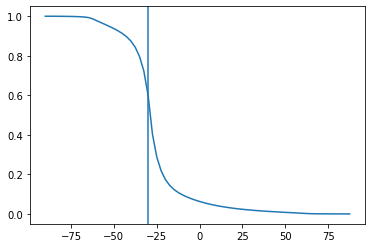

In [271]:
plt.plot(decs, pct)
plt.axvline(-30)

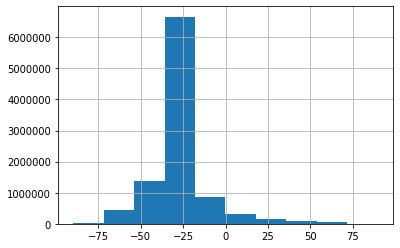

In [265]:
df['dec'].hist()

## Read in sample XRB positions

In [106]:
df = pd.read_csv('../data/sample_xrb_positions_10M.csv.gz', header=None, names=['ra', 'dec', 'd_kpc', 'E(B-V)'])

In [107]:
df

,ra,dec,d_kpc,E(B-V)
0,269.47,-26.09,8.29,3.65
1,266.27,-29.42,8.45,5.59
2,256.26,-44.40,6.49,1.80
3,281.17,-2.29,14.20,5.41
4,264.38,-24.96,8.47,1.55
...,...,...,...,...
9999995,262.12,-38.87,10.80,1.63
9999996,277.20,-11.39,11.31,5.06
9999997,268.46,-27.94,7.87,2.29
9999998,271.04,-25.44,8.23,2.49


### Set assumptions

In [19]:
m_ztf = 20.5  # ZTF limiting mag
del_m = 6  # difference in outburst and quescient mag (optical)
R_V = 3.1  #  E (B-V) to A_v

AV to nH https://arxiv.org/pdf/0903.2057.pdf
E(B_V) to AV https://ned.ipac.caltech.edu/level5/Sept07/Li2/Li2.html
SWIFT catalog https://www.swift.ac.uk/2SXPS/docs.php

In [108]:
distmod = 5 * np.log10(df["d_kpc"] * 1.e3) - 5.0  # Calculate distance modulus for all XRB
df['A_V'] = R_V * df['E(B-V)']   # Calculate extinction
nH = 2.21 * 10 ** 21 * df['A_V']   # column density in cm ** -2

In [109]:
df['nH'] = nH
df['distmod'] = distmod

### Plot abs magnitude (M) required for ztf detection

Text(0.5, 1.0, 'Distance Moduli of Simulated XRBs')

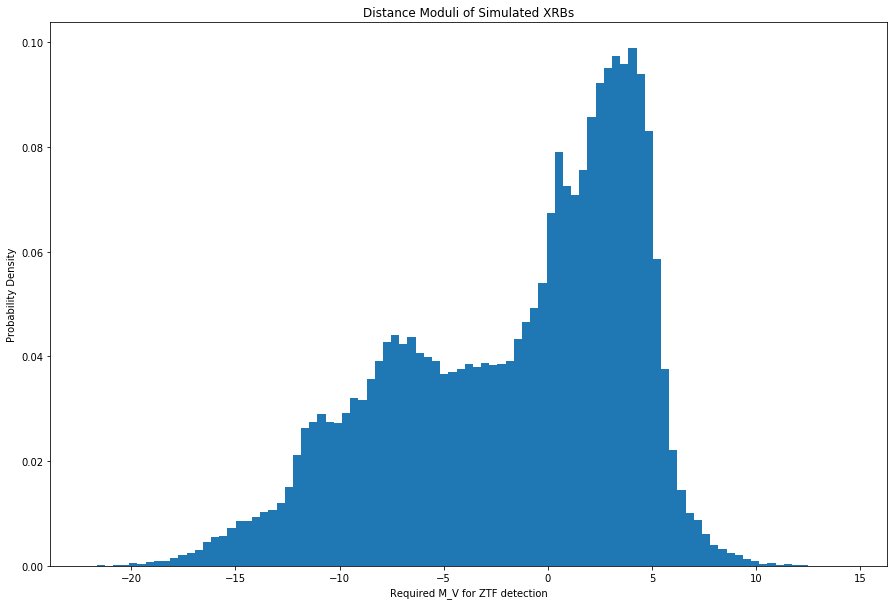

In [359]:
plt.figure(figsize=(15, 10))
M_required = m_ztf - (distmod+df['A_V']).sample(n=100000)
_ = plt.hist(M_required, bins='fd', density=True)
plt.xlabel('Required M_V for ZTF detection')
plt.ylabel('Probability Density')
plt.title('Distance Moduli of Simulated XRBs')

In [38]:
(M_required > 6).sum()

2637

### Assumptions for X-ray flux in outburst and quiescence 

In [110]:
outburst_lum = 10 ** 38 * u.erg  # outburst luminosity
quies_lum = 10 ** 31 * u.erg# quiscent luminosity


In [111]:
df['Oflux'] = outburst_lum / (df['d_kpc'].values ** 2 * u.kpc ** 2).to(u.cm**2).value
df['Qflux'] = quies_lum / (df['d_kpc'].values ** 2 * u.kpc ** 2).to(u.cm**2).value

In [74]:
df['Oflux'].min()

1.1064085237962752e-08

In [76]:
df['Qflux'].quantile([0.05, .9999])


0.0500    4.527924e-15
0.9999    6.247859e-12
Name: Qflux, dtype: float64

### Plot distribution of quiescent fluxes

Text(0.5, 0, 'Flux [$ergs/cm^{2}$]')

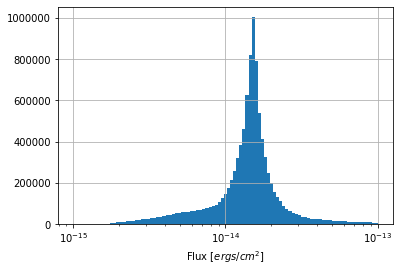

In [137]:
df['Qflux'].hist(bins=np.logspace(-15, -13, 100))
plt.xscale('log')
plt.xlabel("Flux [$ergs/cm^{2}$]")

Text(0.5, 0, 'Flux [1e-15 $ergs/cm^{2}$]')

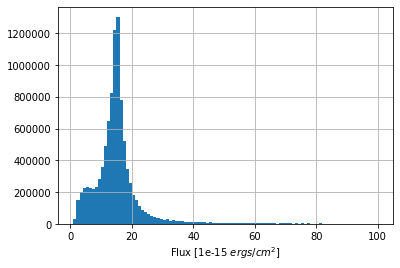

In [148]:
(df['Qflux']*1e15).hist(bins=np.linspace(1, 100, 100))
# plt.xscale('log')
plt.xlabel("Flux [1e-15 $ergs/cm^{2}$]")

### Plot distribution of column densities

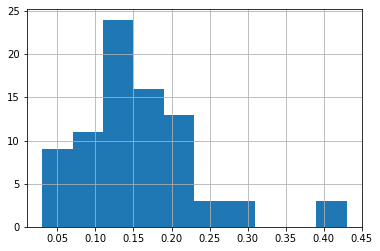

In [155]:
df.query('nH==0')['d_kpc'].hist()

In [151]:
nH.quantile([0.00001,1])

0.00001    6.851000e+19
1.00000    5.741138e+22
Name: A_V, dtype: float64

Text(0.5, 0, 'Column Density [1e22 $cm^{-2}$]')

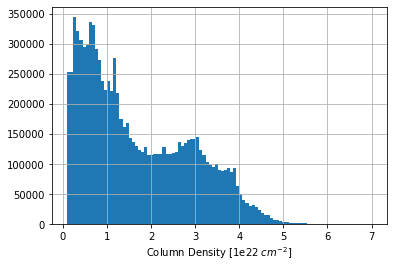

In [146]:
# nH.hist(bins=np.logspace(22, 23, 100))
(nH/1e22).hist(bins=np.linspace(.1, 7, 100))
plt.xlabel("Column Density [1e22 $cm^{-2}$]")

## Use webPIMMs to get count/s estimates

In [245]:
class Interpolate():
    """Interpolates webPIMMs counts to get cps as a function of flux and nH"""
    def __init__(self, WP_output, instr):
        self.data = WP_output
        self.instr = instr
        self.cps_interp = interp1d(self.data['nH'], self.data[instr], kind='quadratic')
        self.data_flux = 1e-15
        assert self.data_flux == self.data['flux'].values[0]
        
        self.factor = 1e7 # Outburst vs quiescence factor
        
        
    def check_interp(self):
        fig, ax = plt.subplots()
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log")
        self.data.plot(x='nH', y=self.instr, ax=ax)
        xs = np.logspace(19, 23, 100)
        ax.plot(xs, self.cps_interp(xs))
        plt.ylabel('Counts/s')
        plt.show()
    
    def get_cps(self, nH, flux, state='Q'):
        factor = 1 
        if state == 'O':
            factor = self.factor
        return self.cps_interp(nH) * flux / self.data_flux # *factor
    
    def plot_cps_distr(self, nH, flux, state='Q'):
        pass

### ROSAT
All sky coverage, 18% of sky in deep field

In [202]:
dfr = pd.DataFrame([(1e-15, 0, 2.276e-5, 1.173e-4),
(1e-15, 3e19, 1.965e-5, 9.185e-5),
(1e-15, 3e20, 1.184e-5, 3.659e-5), 
(1e-15, 3e21, 5.606e-6, 1.486e-5), 
(1e-15, 1e22, 2.190e-6, 5.958e-6), 
(1e-15, 2e22, 8.617e-7, 2.494e-6), 
(1e-15, 3e22, 4.139e-7, 1.263e-6), 
(1e-15, 6e22, 7.425e-8, 2.528e-7), 
(1e-15, 1e23, 1.200e-8, 4.433e-8), 
], columns=['flux', 'nH', 'HRI', 'PSPC'])

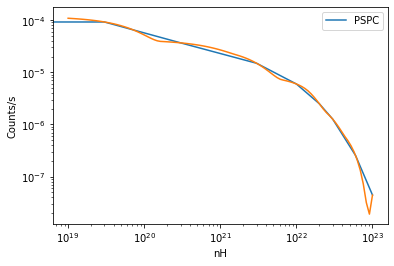

In [246]:
rosat = Interpolate(dfr, 'PSPC')

rosat.check_interp()

In [276]:
rosat_fits = fits.open(data_dir+'rosat_2rxs/cat2rxs.fits')
dfx = pd.DataFrame(rosat_fits[1].data)
rosat_fits.close()

In [277]:
[x for x in dfx.columns if 'exp' in x.lower()]

['EXPOSURE', 'ExpTime_2rxp', 'EXPOS_1rxs', 'Expos_1sxps', 'ExpTime_1rxh']

In [294]:
dfx[[x for x in dfx.columns if 'exp' in x.lower()]].median()

EXPOSURE        4.362368e+02
ExpTime_2rxp   -2.147484e+09
EXPOS_1rxs      3.520000e+02
Expos_1sxps     5.200000e+03
ExpTime_1rxh   -2.147484e+09
dtype: float64

In [314]:
rosat_exp = dfx['EXPOSURE']

### Chandra

In [231]:
dfch = pd.DataFrame([(1e-15, 0, 3.066e-5, 4.083e-5),
(1e-15, 3e19, 3.062e-5, 4.055e-5),
(1e-15, 3e20, 3.020e-5, 3.887e-5), 
(1e-15, 3e21, 2.672e-5, 3.322e-5), 
(1e-15, 1e22, 2.084e-5, 2.520e-5), 
(1e-15, 2e22, 1.614e-5, 1.907e-5), 
(1e-15, 3e22, 1.336e-5, 1.552e-5), 
(1e-15, 6e22, 9.173e-6, 1.024e-5), 
(1e-15, 1e23, 3.696e-6, 7.209e-6)
], columns=['flux', 'nH', 'ACIS-I', 'ACIS-S'])

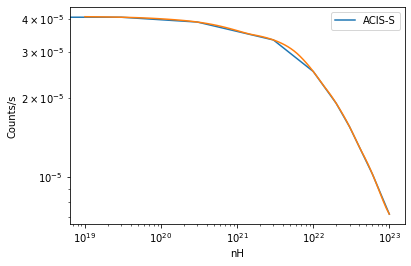

In [247]:
chandra = Interpolate(dfch, 'ACIS-S')

chandra.check_interp()

In [292]:
ch_fits = fits.open(data_dir + 'chandra_csc_v2/IX_57_csc2master.fits.gz')
dfch = pd.DataFrame(ch_fits[1].data)
ch_fits.close()

In [293]:
[x for x in dfch.columns if 'exp' in x.lower()]

['ExpAC', 'ExpHRC']

In [296]:
dfch[[x for x in dfch.columns if 'exp' in x.lower()]].median()

ExpAC     49316.277804
ExpHRC        0.000000
dtype: float64

In [315]:
chandra_exp = dfch['ExpAC']

### XMM
#### 4XMM DR10
Sky coverage: 1192 sq deg
flux map http://xmm-catalog-dev.irap.omp.eu/~mcoriat/shared2/epfluxmap/ (photon ind 1.42, nH 1.7e20)

The median flux in the total photon energy band (0.2 - 12 keV) of the catalogue detections is ~ 8.3 × 10-14 erg cm-2 s-1; in the soft energy band (0.2 - 2 keV) the median flux is ~ 5.3 × 10-15, and in the hard band (2 - 12 keV) it is ~ 1.2 × 10-14. About 23% of the sources have total fluxes below 1 × 10-14 erg cm-2 s-1.
#### XMMSL2
https://www.cosmos.esa.int/web/xmm-newton/xmmsl2-ug
The median flux is 3.0E-12 ergs/s/cm2 in the total band, 1.2E-12 in the soft band and 9.3E-12 in the hard band in the clean catalogue.

In [239]:
dfxmm = pd.DataFrame([(1e-15, 0, 5.076e-4, 3.017e-4),
(1e-15, 3e19, 4.838e-4, 2.956e-4),
(1e-15, 3e20, 3.586e-4, 2.564e-4), 
(1e-15, 1e21, 2.527e-4, 2.042e-4), 
(1e-15, 3e21, 1.617e-4, 1.414e-4), 
(1e-15, 1e22, 8.717e-5, 8.088e-5), 
(1e-15, 2e22, 5.900e-5, 5.612e-5), 
(1e-15, 3e22, 4.635e-5, 4.475e-5), 
(1e-15, 6e22, 3.010e-5, 3.112e-5), 
(1e-15, 1e23, 2.167e-5, 2.190e-5)
], columns=['flux', 'nH', 'PN-THIN', 'PN-THICK'])

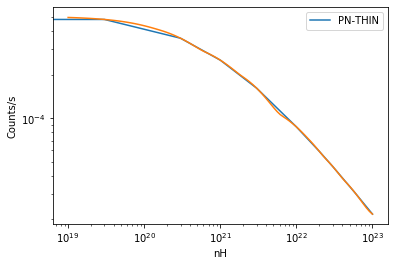

In [248]:
xmm = Interpolate(dfxmm, 'PN-THIN')

xmm.check_interp()

In [278]:
def clean_bytes_cols(df):
    # convert bytes to string
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        # also strip off extra whitespace
        df[col] = str_df[col].str.strip()

In [279]:
dfxmmsl = Table.read(data_dir + 'xmm_sl2/xmmsl2_clean.fits').to_pandas()
clean_bytes_cols(dfxmmsl)

In [280]:
[x for x in dfxmmsl.columns if 'exp' in x.lower()]

['EXP_MAP_B8', 'EXP_MAP_B7', 'EXP_MAP_B6']

In [306]:
dfxmmsl['DATE_END'] = pd.to_datetime(dfxmmsl['DATE_END'])
dfxmmsl['DATE_OBS'] = pd.to_datetime(dfxmmsl['DATE_OBS'])

In [311]:
(dfxmmsl['DATE_END'] - dfxmmsl['DATE_OBS']).dt.seconds

0        5146
1        5146
2        5146
3        5146
4        5146
         ... 
29388    3350
29389    3350
29390    3350
29391    3350
29392    3350
Length: 29393, dtype: int64

In [312]:
dfxmmsl['exposure'] = (dfxmmsl['DATE_END'] - dfxmmsl['DATE_OBS']).dt.seconds

In [316]:
xmmsl_exp = dfxmmsl['exposure']

In [281]:
dfxmm10 = Table.read(data_dir + 'xmm_4xmm_dr10/4XMM_DR10cat_slim_v1.0.fits.gz').to_pandas()
clean_bytes_cols(dfxmm10)

In [285]:
dfxmm10['exposure'] = (dfxmm10['MJD_LAST'] - dfxmm10['MJD_FIRST']) * 86400

In [317]:
xmm_exp = dfxmm10['exposure']

### Swift
https://www.swift.ac.uk/2SXPS/docs.php
sky coverage: 3790 sq deg

Typical sens
2×10-13 erg cm-2 s-1 (observations)
4×10-14 erg cm-2 s-1 (stacked images)

In [241]:
dfs = pd.DataFrame([(1e-15, 0, 2.222e-5, 2.276e-5),
(1e-15, 3e19, 2.199e-5, 2.696e-5),
(1e-15, 3e20, 2.016e-5, 2.464e-5), 
(1e-15, 3e21, 1.26e-5, 1.481e-5), 
(1e-15, 1e22, 7.772e-6, 8.93e-6), 
(1e-15, 2e22, 5.484e-6, 6.28e-6), 
(1e-15, 3e22, 4.370e-6, 5.009e-6), 
(1e-15, 6e22, 2.860e-6, 3.301e-6), 
(1e-15, 1e23, 2.033e-6, 2.366e-6)
], columns=['flux', 'nH', 'XRT PC', 'XRT PD'])

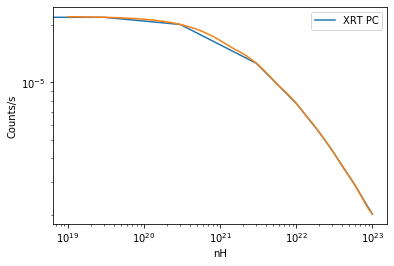

In [249]:
swift = Interpolate(dfs, 'XRT PC')

swift.check_interp()

In [290]:
sw_fits = fits.open(data_dir + 'swift_2sxps/2SXPS_Sources_clean.fits.gz')
dfsw = pd.DataFrame(sw_fits[1].data)
sw_fits.close()

In [295]:
[x for x in dfsw.columns if 'exp' in x.lower()]

['Exposure']

(0, 1000000.0)

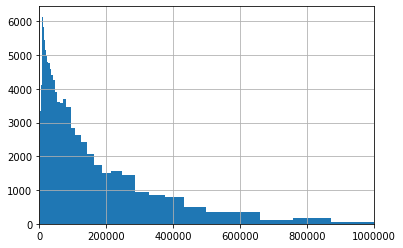

In [291]:
dfsw['Exposure'].hist(bins=np.logspace(0, 6, 100))
plt.xlim([0, 1e6])

In [318]:
swift_exp = dfsw['Exposure']

## counts per second

In [ ]:
df['Qcps_r']

In [250]:
df['Qcps_r'] = rosat.get_cps(df['nH'], df['Qflux'])
df['Ocps_r'] = rosat.get_cps(df['nH'], df['Oflux'])
df['Qcps_ch'] = chandra.get_cps(df['nH'], df['Qflux'])
df['Ocps_ch'] = chandra.get_cps(df['nH'], df['Oflux'])
df['Qcps_x'] = xmm.get_cps(df['nH'], df['Qflux'])
df['Ocps_x'] = xmm.get_cps(df['nH'], df['Oflux'])

df['Qcps_s'] = swift.get_cps(df['nH'], df['Qflux'])
df['Ocps_s'] = swift.get_cps(df['nH'], df['Oflux'])

In [251]:
counts_features = [x for x in df.columns if 'cps' in x]

In [343]:
def plot_loghist(series, nbins=100):
        lb, ub = series.quantile([0.01, 0.99])
        loglb = np.floor(np.log10(lb))
        logub = np.ceil(np.log10(ub))
        series.hist(bins=np.logspace(loglb, logub, nbins))
        plt.show()

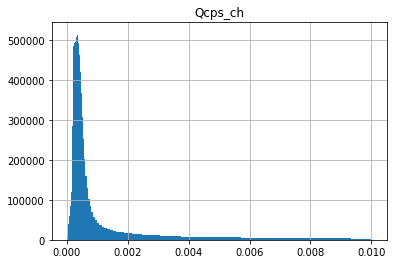

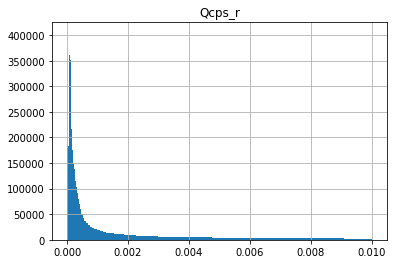

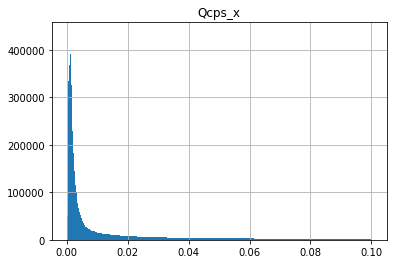

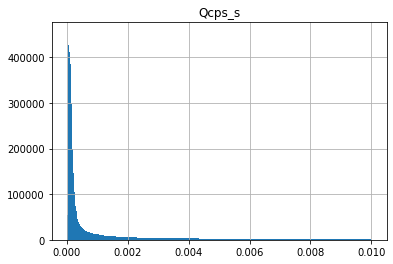

In [261]:
for ff in counts_features:
    if 'Q' in ff:
        lb, ub = df[ff].quantile([0.01, 0.99])
        loglb = np.floor(np.log10(lb))
        logub = np.ceil(np.log10(ub))
        df[ff].hist(bins=np.logspace(loglb, logub, 100))
        plt.title(ff)
        plt.show()

### N detections Expected

In [ ]:
total_sky = 41253 # sq deg

#### ROSAT

In [319]:
area = 41253

In [347]:
def find_ev(Qcps, exp, snr_thres = 5):
    plot_loghist(exp)
    plot_loghist(Qcps)
    exp_med = exp.median()
    snr = (Qcps * exp_med) / np.sqrt(Qcps * exp_med)
    plot_loghist(snr)
    return sum(snr > snr_thres) / len(snr)

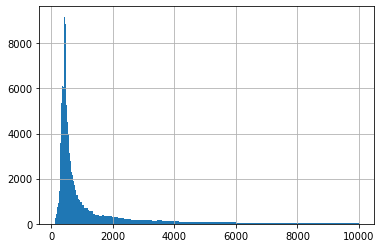

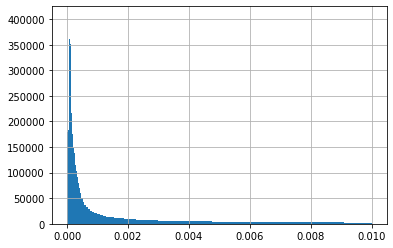

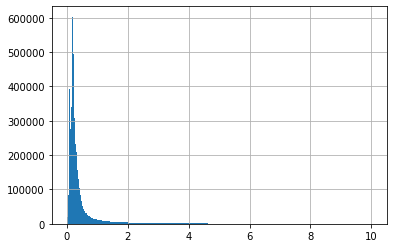

0.0004771

In [345]:
find_ev(df['Qcps_r'], rosat_exp)

### Chandra

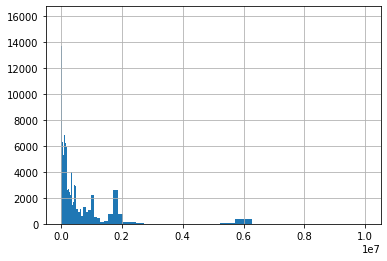

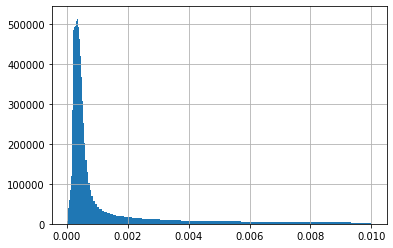

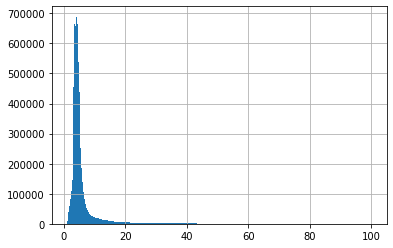

0.1818257

In [348]:
find_ev(df['Qcps_ch'], chandra_exp)

### Swift

In [358]:
coverage = 3790

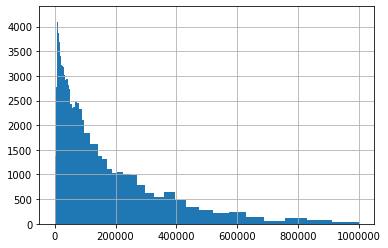

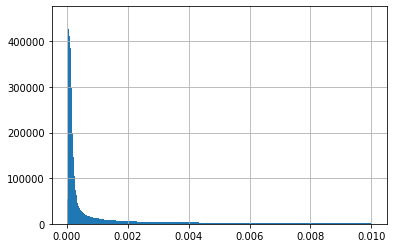

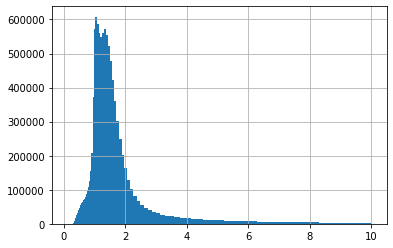

0.0117322

In [349]:
find_ev(df['Qcps_s'], swift_exp)

### XMM

In [ ]:
coverage = 1192 

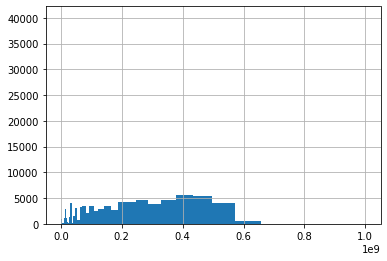

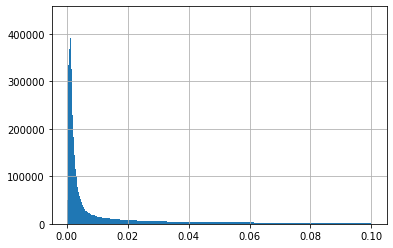

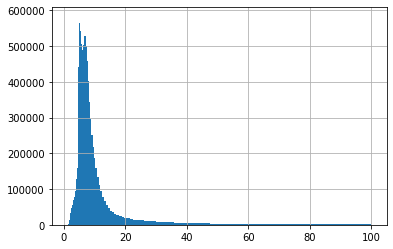

0.7718718

In [350]:
find_ev(df['Qcps_x'], xmm_exp)

(array([2.888e+04, 3.400e+01, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        6.100e+01, 6.000e+00, 6.000e+00, 3.950e+02]),
 array([    0. ,  8639.9, 17279.8, 25919.7, 34559.6, 43199.5, 51839.4,
        60479.3, 69119.2, 77759.1, 86399. ]),
 <a list of 10 Patch objects>)

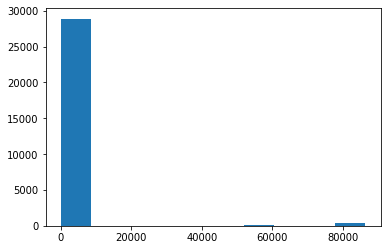

In [357]:
plt.hist(xmmsl_exp)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


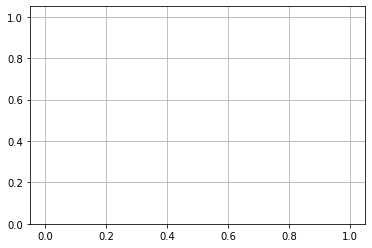

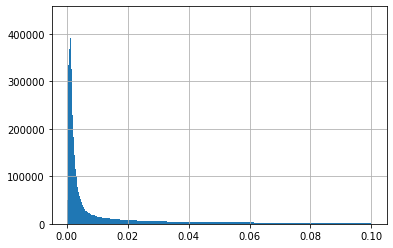

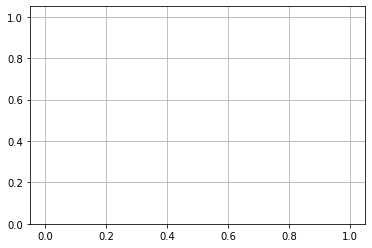

0.0

In [356]:
find_ev(df['Qcps_x'], xmmsl_exp.astype(float))

In [127]:
df['Ocps_r'] = ROSAT_approx(df['Oflux'])

In [114]:
df['Qcps_ch'] = chandra_approx(df['Qflux'])

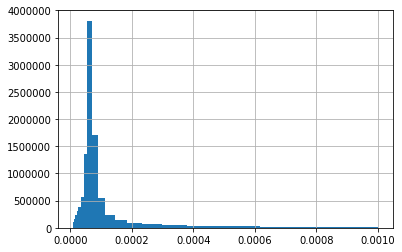

In [120]:
df['Qcps_ch'].hist(bins=np.logspace(-5, -3, 20))

In [124]:
df['Qcps_ch'].quantile([.95, .99, .999, .9999, .99999, 1])

0.95000    0.000146
0.99000    0.000576
0.99900    0.004280
0.99990    0.026491
0.99999    0.137442
1.00000    4.947915
Name: Qcps_ch, dtype: float64

In [128]:
df['Qcps_r'].quantile([.95, .99, .999, .9999, .99999, 1])

0.95000    0.000014
0.99000    0.000054
0.99900    0.000405
0.99990    0.002505
0.99999    0.012999
1.00000    0.467951
Name: Qcps_r, dtype: float64

In [130]:
(df['Qcps_r'] > 0.05).sum()

20

In [133]:
(df['Qcps_r'] > 0.1).sum()

11

In [255]:
df['Qcps_r'].quantile([.1, .5, .95, .99, .999, .9999, .99999, 1])

0.10000      0.000011
0.50000      0.000064
0.95000      0.000450
0.99000      0.002375
0.99900      0.028726
0.99990      0.224182
0.99999      2.416028
1.00000    136.884544
Name: Qcps_r, dtype: float64

Text(0, 0.5, 'Counts/s')

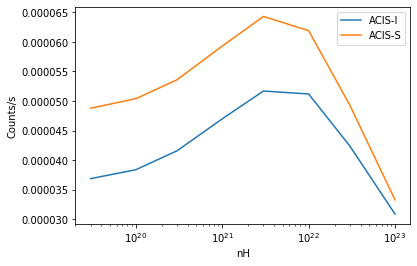

In [101]:
fig, ax = plt.subplots()
# optionally make log scale
ax.set_xscale("log", nonposx='clip')
df.plot(x='nH', y='ACIS-I', ax=ax)
df.plot(x='nH', y='ACIS-S', ax=ax)
plt.ylabel('Counts/s')

In [ ]:
hearsac_chandra

In [91]:
import astropy.units as u

In [95]:
(0.01 * u.cm**-3 * 40 * u.kpc**3).decompose()

<Quantity 1.17519958e+64>

In [96]:
4/(2**1.5)

1.414213562373095

In [97]:
np.pi/(np.pi**1.5)

0.5641895835477563

In [98]:
1/(np.sqrt(np.pi))

0.5641895835477563

 ROSAT PSPC countrate of 0.05 cts/s in the energy band 0.1- 2.4 keV